# Assets Monitored with Maximo Meters

**Category:** AssetMeter Table
**Scope:** Site-Specific   
**Author:** Michael Moyer   
**Created:** 01-26-2026   
**Last Updated:** 01-26-2026  

**Purpose:** Identifies Assets wih Meters that have meters. Last reading date and Condition Monitoring point tie-in are noted as well. 

Notebook gathers the data, organizes, cleans and provides a brief report on it. 
        
**Use Case:** Use this notebook to detect assets with Condition Monitoring according to whether or not there is an 'active'* meter on the asset. 

---

In [1]:
NOTEBOOK_NAME = 'acm_assets_meters-coverage'
sql_file = f'{NOTEBOOK_NAME}.sql'

## Step 0: Load Packages and SQL Script

### 0.0 Package Load

In [2]:
import pandas as pd
import os
import pyodbc
import re

from dotenv import load_dotenv, find_dotenv
from pathlib import Path


import warnings
import time       # for timing longer cells (running the sql query)
import matplotlib.pyplot as plt
from datetime import datetime,timedelta

### 0.1 Credentials Load

In [3]:
# Automatically search for .env in parent directories
load_dotenv(find_dotenv())

# Load from environment variables
DSN = os.getenv('MAXIMO_DSN')
USER = os.getenv('MAXIMO_USER')
PASSWORD = os.getenv('MAXIMO_PASS')

print(f"DSN: {DSN}")
print(f"User: {USER}")

DSN: MX76PROD
User: maximo7


### 0.2 Define Query Pull Function

In [4]:
# Suppress the pandas warning
warnings.filterwarnings('ignore', category=UserWarning)

def run_query_from_file(sql_path: str) -> pd.DataFrame:
    conn = pyodbc.connect(f"DSN={DSN};UID={USER};PWD={PASSWORD}")
    query = open(sql_path).read()
    df = pd.read_sql(query, conn)
    conn.close()
    return df

## Step 1: Pull Data
### 1.1 Run & Time the Query

Check the file names

In [5]:
print(f"Notebook: {NOTEBOOK_NAME}.ipynb")
print(f"Matching Script: {sql_file}")

Notebook: acm_assets_meters-coverage.ipynb
Matching Script: acm_assets_meters-coverage.sql


Run the query and time the execution of it.

In [6]:
# Start timing
start_time = time.time()

# Run the sql script
df_raw = run_query_from_file(sql_file)

# Calculate and print execution time
execution_time = time.time() - start_time
print(f"Query execution time: {execution_time:.2f} seconds \n")

Query execution time: 17.28 seconds 



### 1.2 Basic Shape / Information

In [7]:
print(f"Raw Data Frame Shape: {df_raw.shape[0]:,} rows, {df_raw.shape[1]} columns \n")
print("--- DataFrame Info---\n")
print(df_raw.info(), "\n\n--- null value detection---\n\n", df_raw.isna().sum())
#Memory Usage
print("")
print(f"Memory usage: {df_raw.memory_usage(deep=True).sum() / 1024**2:.2f} MB")

Raw Data Frame Shape: 24,091 rows, 15 columns 

--- DataFrame Info---

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 24091 entries, 0 to 24090
Data columns (total 15 columns):
 #   Column              Non-Null Count  Dtype         
---  ------              --------------  -----         
 0   ASSETNUM            24091 non-null  object        
 1   DESCRIPTION         24091 non-null  object        
 2   METERNAME           24091 non-null  object        
 3   METERDESCRIPTION    24091 non-null  object        
 4   METERTYPE           24091 non-null  object        
 5   AVGCALCMETHOD       4603 non-null   object        
 6   ROLLDOWNSOURCE      4521 non-null   object        
 7   REMARKS             20187 non-null  object        
 8   POINTNUM            8920 non-null   object        
 9   LASTREADING         18412 non-null  object        
 10  LASTREADING_DATE    18523 non-null  datetime64[ns]
 11  CHANGEBY            24091 non-null  object        
 12  LASTREADINGINSPCTR  18521 non-n

### 1.3 Asses Missingness (remove 100% empty columns)

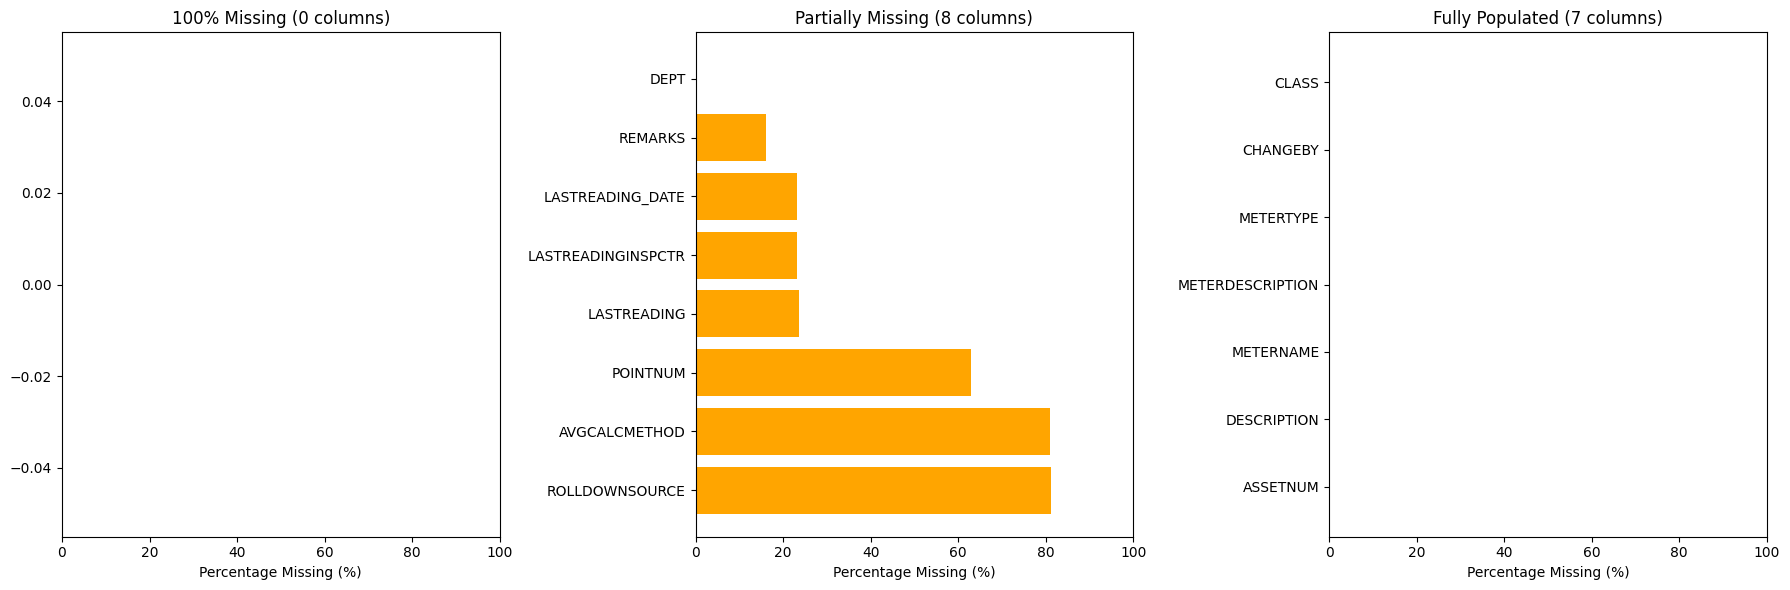

In [8]:
#Converting to dataframe
missing_df_raw = df_raw.isna().sum().to_frame(name='count')

#Add column for percentage of total that are missing
missing_df_raw['percentage'] =  100 - (((df_raw.shape[0] - missing_df_raw['count'])/df_raw.shape[0]) * 100)

# Sort by percentage descending
# Separate into three categories
missing_100 = missing_df_raw[missing_df_raw['percentage'] == 100].sort_values('percentage', ascending=False)
missing_partial = missing_df_raw[(missing_df_raw['percentage'] > 0) & (missing_df_raw['percentage'] < 100)].sort_values('percentage', ascending=False)
missing_0 = missing_df_raw[missing_df_raw['percentage'] == 0].sort_values('percentage', ascending=False)

# Create 1x3 subplots
fig, axes = plt.subplots(1, 3, figsize=(18, 6))

# Chart 1: 100% missing
axes[0].barh(missing_100.index, missing_100['percentage'], color='red')
axes[0].set_xlabel('Percentage Missing (%)')
axes[0].set_title(f'100% Missing ({len(missing_100)} columns)')
axes[0].set_xlim(0, 100)

# Chart 2: Partial missing
axes[1].barh(missing_partial.index, missing_partial['percentage'], color='orange')
axes[1].set_xlabel('Percentage Missing (%)')
axes[1].set_title(f'Partially Missing ({len(missing_partial)} columns)')
axes[1].set_xlim(0, 100)

# Chart 3: 0% missing (fully populated)
axes[2].barh(missing_0.index, missing_0['percentage'], color='green')
axes[2].set_xlabel('Percentage Missing (%)')
axes[2].set_title(f'Fully Populated ({len(missing_0)} columns)')
axes[2].set_xlim(0, 100)

plt.tight_layout()
plt.show()

In [9]:
display(missing_df_raw)

,count,percentage
ASSETNUM,0,0.000000
DESCRIPTION,0,0.000000
METERNAME,0,0.000000
METERDESCRIPTION,0,0.000000
METERTYPE,0,0.000000
AVGCALCMETHOD,19488,80.893280
ROLLDOWNSOURCE,19570,81.233656
REMARKS,3904,16.205222
POINTNUM,15171,62.973725
LASTREADING,5679,23.573119


## Step 2: Clean & Inspect Data
### 2.1 Dtype Conversion

In [10]:
# Primary Conversions
df_raw['METERTYPE'] = df_raw['METERTYPE'].astype('category')
df_raw['ASSETNUM'] = df_raw['ASSETNUM'].astype('category')
df_raw['METERNAME'] = df_raw['METERNAME'].astype('category')
df_raw['LASTREADINGINSPCTR'] = df_raw['LASTREADINGINSPCTR'].astype('category')


# Verify
print(df_raw.info())

#Memory Usage
print(f"Memory usage: {df_raw.memory_usage(deep=True).sum() / 1024**2:.2f} MB")

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 24091 entries, 0 to 24090
Data columns (total 15 columns):
 #   Column              Non-Null Count  Dtype         
---  ------              --------------  -----         
 0   ASSETNUM            24091 non-null  category      
 1   DESCRIPTION         24091 non-null  object        
 2   METERNAME           24091 non-null  category      
 3   METERDESCRIPTION    24091 non-null  object        
 4   METERTYPE           24091 non-null  category      
 5   AVGCALCMETHOD       4603 non-null   object        
 6   ROLLDOWNSOURCE      4521 non-null   object        
 7   REMARKS             20187 non-null  object        
 8   POINTNUM            8920 non-null   object        
 9   LASTREADING         18412 non-null  object        
 10  LASTREADING_DATE    18523 non-null  datetime64[ns]
 11  CHANGEBY            24091 non-null  object        
 12  LASTREADINGINSPCTR  18521 non-null  category      
 13  CLASS               24091 non-null  object    

In [11]:
df_raw.head(5)
df_raw.to_csv('meters-coverage_raw.csv')

In [12]:
# Export to CSV
timestamp = datetime.now().strftime('%Y%m%d_%H%M')
csv_filename = f'{NOTEBOOK_NAME}_{timestamp}.csv'
df_raw.to_csv(csv_filename, index=False)

print(f"\nAll records exported to: {csv_filename}")
print(f"Total records exported: {len(df_raw)}")


All records exported to: acm_assets_meters-coverage_20260126_1101.csv
Total records exported: 24091


In [13]:
df_raw.nunique()

ASSETNUM               8223
DESCRIPTION            8102
METERNAME               633
METERDESCRIPTION        618
METERTYPE                 3
AVGCALCMETHOD             4
ROLLDOWNSOURCE            3
REMARKS                3795
POINTNUM               8908
LASTREADING            3199
LASTREADING_DATE      14819
CHANGEBY                337
LASTREADINGINSPCTR      298
CLASS                   109
DEPT                     30
dtype: int64

## Step 1: Export Flagged Records (Null Last Reading Date)

In [14]:
# Isolate records with null LASTREADING_DATE
df_flagged = df_raw[df_raw['LASTREADING_DATE'].isna()].copy()

print(f"Flagged records (null LASTREADING_DATE): {len(df_flagged):,}")
print(f"Percentage of total: {len(df_flagged)/len(df_raw)*100:.1f}%")

# Export flagged records for business review
df_flagged.to_csv('meters_flagged_null_readings.csv', index=False)
print("\nExported: meters_flagged_null_readings.csv")

# Show sample of flagged records
print("\nSample of flagged records:")
df_flagged.head()

Flagged records (null LASTREADING_DATE): 5,568
Percentage of total: 23.1%

Exported: meters_flagged_null_readings.csv

Sample of flagged records:


,ASSETNUM,DESCRIPTION,METERNAME,METERDESCRIPTION,METERTYPE,AVGCALCMETHOD,ROLLDOWNSOURCE,REMARKS,POINTNUM,LASTREADING,LASTREADING_DATE,CHANGEBY,LASTREADINGINSPCTR,CLASS,DEPT
0,A100001,"PEOPLE MOVER, OHC-1, WT02 PLATFORM",20MVCOREPN,20 Moving Core Pin,GAUGE,None,None,5MX MC Die Moving Die Core Pin ML1,None,None,NaT,MA14719,NaN,Conveyor,1AF
1,A100001,"PEOPLE MOVER, OHC-1, WT02 PLATFORM",01CYCLES,CYCLES 1,CONTINUOUS,ALL,ASSET,Shots,None,None,NaT,MAXADMIN,NaN,Conveyor,1AF
2,A100001,"PEOPLE MOVER, OHC-1, WT02 PLATFORM",01FXCOREPN,01 Fixed Core Pin,GAUGE,None,None,5MX MC Die Fixed Die Core Pin FE,None,None,NaT,MA14719,NaN,Conveyor,1AF
3,A100001,"PEOPLE MOVER, OHC-1, WT02 PLATFORM",01LTCOREPN,01 Left Core Pin,GAUGE,None,None,5MX MC Die LEFT Core Pin LK2,None,None,NaT,MA14719,NaN,Conveyor,1AF
4,A100001,"PEOPLE MOVER, OHC-1, WT02 PLATFORM",01MVCOREPN,01 Moving Core Pin,GAUGE,None,None,5MX MC Die Moving Die Core Pin ME,None,None,NaT,MA14719,NaN,Conveyor,1AF


## Step 2: Aggregate to Asset Level

In [22]:
# Aggregate to ASSETNUM level
df_agg = df_raw.groupby('ASSETNUM', observed=False).agg({
    'METERNAME': 'count',  # Count of meters
    'LASTREADING_DATE': 'max',  # Most recent reading date
    'DESCRIPTION': 'first',  # Get asset description (should be same for all records)
    'CLASS': 'first',
    'DEPT': 'first'
}).reset_index()

# Rename columns for clarity
df_agg.columns = ['ASSETNUM', 'METER_COUNT', 'MAX_LASTREADING_DATE', 'ASSET_DESCRIPTION','DEPT','CLASS']

print(f"Total unique assets: {len(df_agg):,}")
print(f"\nAggregated data sample:")
df_agg.head(10)

Total unique assets: 8,223

Aggregated data sample:


,ASSETNUM,METER_COUNT,MAX_LASTREADING_DATE,ASSET_DESCRIPTION,DEPT,CLASS
0,A100001,83,NaT,"PEOPLE MOVER, OHC-1, WT02 PLATFORM",Conveyor,1AF
1,A100002,91,2026-01-20 20:27:09.260,SMURF REAR INSTALL ROBOT END OF ARM TOOL - ODY...,Head Assembly,1AF
2,A100003,84,2024-05-10 17:11:50.072,SMURF FRONT INSTALL ROBOT END OF ARM TOOL - RI...,Head Assembly,1AF
3,A100004,88,2026-01-20 20:28:24.798,SMURF FRONT INSTALL ROBOT END OF ARM TOOL - OD...,Head Assembly,1AF
4,A100005,84,2025-12-05 01:01:06.922,KNUCKLE ISLAND BEARING PRESS #2,Press,1AF
5,A100006,84,2024-05-23 12:16:17.124,KNUCKLE ISLAND BEARING PRESS #1,Press,1AF
6,A100007,1,NaT,REAR KNUCKLE AUTO TIGHTEN (PARENT),Power Tool,1AF
7,A100008,1,NaT,"INLINE BURNISHING MACHINE (PARENT), BURNISHER",Grinder,1AF
8,A100009,1,NaT,REAR SUSPENSION CONVEYOR (PARENT),Power Tool,1AF
9,A100010,1,NaT,REAR SUSPENSION AUTO TIGHTEN (PARENT),Power Tool,1AF


## Step 3: Add Calculated Columns

In [23]:
# Calculate date threshold (1 year ago from today)
one_year_ago = datetime.now() - timedelta(days=365)
print(f"One year ago threshold: {one_year_ago.date()}")

# Add "Last Reading Within 1 Year" column
df_agg['READING_WITHIN_1YR'] = df_agg['MAX_LASTREADING_DATE'].apply(
    lambda x: 'Y' if pd.notna(x) and x >= one_year_ago else 'N'
)

# Count and display results
reading_counts = df_agg['READING_WITHIN_1YR'].value_counts()
print(f"\nReading within 1 year distribution:")
print(reading_counts)
print(f"\nPercentage with recent readings: {reading_counts.get('Y', 0)/len(df_agg)*100:.1f}%")

df_agg.head(10)

One year ago threshold: 2025-01-26

Reading within 1 year distribution:
READING_WITHIN_1YR
Y    5005
N    3218
Name: count, dtype: int64

Percentage with recent readings: 60.9%


,ASSETNUM,METER_COUNT,MAX_LASTREADING_DATE,ASSET_DESCRIPTION,DEPT,CLASS,READING_WITHIN_1YR
0,A100001,83,NaT,"PEOPLE MOVER, OHC-1, WT02 PLATFORM",Conveyor,1AF,N
1,A100002,91,2026-01-20 20:27:09.260,SMURF REAR INSTALL ROBOT END OF ARM TOOL - ODY...,Head Assembly,1AF,Y
2,A100003,84,2024-05-10 17:11:50.072,SMURF FRONT INSTALL ROBOT END OF ARM TOOL - RI...,Head Assembly,1AF,N
3,A100004,88,2026-01-20 20:28:24.798,SMURF FRONT INSTALL ROBOT END OF ARM TOOL - OD...,Head Assembly,1AF,Y
4,A100005,84,2025-12-05 01:01:06.922,KNUCKLE ISLAND BEARING PRESS #2,Press,1AF,Y
5,A100006,84,2024-05-23 12:16:17.124,KNUCKLE ISLAND BEARING PRESS #1,Press,1AF,N
6,A100007,1,NaT,REAR KNUCKLE AUTO TIGHTEN (PARENT),Power Tool,1AF,N
7,A100008,1,NaT,"INLINE BURNISHING MACHINE (PARENT), BURNISHER",Grinder,1AF,N
8,A100009,1,NaT,REAR SUSPENSION CONVEYOR (PARENT),Power Tool,1AF,N
9,A100010,1,NaT,REAR SUSPENSION AUTO TIGHTEN (PARENT),Power Tool,1AF,N


## Step 4: Add HAS_GM Column (Conditional on Recent Reading)

In [24]:
# HAS_GM is only 'Y' if READING_WITHIN_1YR is 'Y'
# This follows the logic: "if this is Y... then another column (same calculation) HAS_GM = Y/N"
df_agg['HAS_GM'] = df_agg['READING_WITHIN_1YR'].apply(
    lambda x: 'Y' if x == 'Y' else 'N'
)

# Display results
print("Distribution of HAS_GM:")
print(df_agg['HAS_GM'].value_counts())

# Cross-tabulation to verify logic
print("\nCross-tabulation (READING_WITHIN_1YR vs HAS_GM):")
print(pd.crosstab(df_agg['READING_WITHIN_1YR'], df_agg['HAS_GM']))

print("\nFinal aggregated data sample:")
df_agg.head(10)

Distribution of HAS_GM:
HAS_GM
Y    5005
N    3218
Name: count, dtype: int64

Cross-tabulation (READING_WITHIN_1YR vs HAS_GM):
HAS_GM                 N     Y
READING_WITHIN_1YR            
N                   3218     0
Y                      0  5005

Final aggregated data sample:


,ASSETNUM,METER_COUNT,MAX_LASTREADING_DATE,ASSET_DESCRIPTION,DEPT,CLASS,READING_WITHIN_1YR,HAS_GM
0,A100001,83,NaT,"PEOPLE MOVER, OHC-1, WT02 PLATFORM",Conveyor,1AF,N,N
1,A100002,91,2026-01-20 20:27:09.260,SMURF REAR INSTALL ROBOT END OF ARM TOOL - ODY...,Head Assembly,1AF,Y,Y
2,A100003,84,2024-05-10 17:11:50.072,SMURF FRONT INSTALL ROBOT END OF ARM TOOL - RI...,Head Assembly,1AF,N,N
3,A100004,88,2026-01-20 20:28:24.798,SMURF FRONT INSTALL ROBOT END OF ARM TOOL - OD...,Head Assembly,1AF,Y,Y
4,A100005,84,2025-12-05 01:01:06.922,KNUCKLE ISLAND BEARING PRESS #2,Press,1AF,Y,Y
5,A100006,84,2024-05-23 12:16:17.124,KNUCKLE ISLAND BEARING PRESS #1,Press,1AF,N,N
6,A100007,1,NaT,REAR KNUCKLE AUTO TIGHTEN (PARENT),Power Tool,1AF,N,N
7,A100008,1,NaT,"INLINE BURNISHING MACHINE (PARENT), BURNISHER",Grinder,1AF,N,N
8,A100009,1,NaT,REAR SUSPENSION CONVEYOR (PARENT),Power Tool,1AF,N,N
9,A100010,1,NaT,REAR SUSPENSION AUTO TIGHTEN (PARENT),Power Tool,1AF,N,N


## Step 5: Summary Statistics

In [25]:
# Summary statistics
print("=" * 60)
print("SUMMARY STATISTICS")
print("=" * 60)

print(f"\nTotal Assets: {len(df_agg):,}")
print(f"Total Meters: {df_agg['METER_COUNT'].sum():,}")
print(f"Average Meters per Asset: {df_agg['METER_COUNT'].mean():.2f}")
print(f"Median Meters per Asset: {df_agg['METER_COUNT'].median():.0f}")
print(f"Max Meters on Single Asset: {df_agg['METER_COUNT'].max()}")

print(f"\nAssets with Recent Readings (within 1 year): {(df_agg['READING_WITHIN_1YR'] == 'Y').sum():,}")
print(f"Assets with HAS_GM = Y: {(df_agg['HAS_GM'] == 'Y').sum():,}")
print(f"Assets with no recent readings: {(df_agg['READING_WITHIN_1YR'] == 'N').sum():,}")

print(f"\nAssets with null MAX_LASTREADING_DATE: {df_agg['MAX_LASTREADING_DATE'].isna().sum():,}")

SUMMARY STATISTICS

Total Assets: 8,223
Total Meters: 24,091
Average Meters per Asset: 2.93
Median Meters per Asset: 2
Max Meters on Single Asset: 151

Assets with Recent Readings (within 1 year): 5,005
Assets with HAS_GM = Y: 5,005
Assets with no recent readings: 3,218

Assets with null MAX_LASTREADING_DATE: 817


## Step 6: Export Processed Data

In [27]:
# Export main aggregated data as pickle for merging with SQL Routes
df_agg.to_pickle('meters-coverage.pkl')
print("Exported: meters-main.pkl")

# Also export as CSV for easy review
df_agg.to_csv('meters_main.csv', index=False)
print("Exported: meters_main.csv")

# Export flagged data as pickle as well
df_flagged.to_pickle('meters_flagged.pkl')
print("Exported: meters_flagged.pkl")

print("\n" + "=" * 60)
print("PROCESSING COMPLETE")
print("=" * 60)
print("\nNext step: Merge meters_main.pkl with SQL Routes data")

Exported: meters_main.pkl
Exported: meters_main.csv
Exported: meters_flagged.pkl

PROCESSING COMPLETE

Next step: Merge meters_main.pkl with SQL Routes data


In [20]:
# Export to CSV
OUTPUT_NAME = 'meters-coverage'
timestamp = datetime.now().strftime('%Y%m%d_%H%M')
csv_filename = f'{OUTPUT_NAME}_{timestamp}.csv'